In [1]:
from itertools import product
import numpy as np
from scipy import optimize
from scipy import interpolate
import sympy as sm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn-whitegrid')
import seaborn as sns

%load_ext autoreload
%autoreload 2
import ASAD

# 1. Human capital accumulation

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
b = 1
w = 2
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

The **basic functions** are:

In [4]:
def consumption_utility(c,rho):
    """ utility of consumption
    
    Args:
    
        c (float): consumption
        rho (float): CRRA parameter
        
    Returns:
    
        (float): utility of consumption
    
    """
    
    return c**(1-rho)/(1-rho)

def labor_disutility(l,gamma):
    """ disutility of labor
    
    Args:
    
        l (int): labor supply
        gamma (float): disutility of labor parameter
        
    Returns:
    
        (float): disutility of labor
    
    """
    
    return gamma*l

def consumption(h,l,w,b):
    """ consumption
    
    Args:
    
        h (float): human capital
        l (int): labor supply
        w (float): wage rate
        b (float): unemployment benefits
        
    Returns:
    
        (float): consumption
    
    """
    
    if l == 1:
        return w*h
    else:
        return b

The **value-of-choice functions** are:

In [5]:
def v2(l2,h2,b,w,rho,gamma):
    """ value-of-choice in period 2
    
    Args:
    
        l2 (int): labor supply
        h2 (float): human capital
        w (float): wage rate
        b (float): unemployment benefits
        rho (float): CRRA parameter        
        gamma (float): disutility of labor parameter        
        
    Returns:
    
        (float): value-of-choice in period 2
    
    """
    
    c2 = consumption(h2,l2,w,b)
    return consumption_utility(c2,rho)-labor_disutility(l2,gamma)

def v1(l1,h1,b,w,rho,gamma,Delta,v2_interp,eta=1):
    """ value-of-choice in period 1
    
    Args:
    
        l1 (int): labor supply
        h1 (float): human capital
        w (float): wage rate
        b (float): unemployment benefits
        rho (float): CRRA parameter        
        gamma (float): disutility of labor parameter        
        Delta (float): potential stochastic experience gain
        v2_interp (RegularGridInterpolator): interpolator for value-of-choice in period 2
        eta (float,optional): scaling of determistic experience gain
        
    Returns:
    
        (float): value-of-choice in period 1
    
    """
    
    # a. v2 value, if no experience gain
    h2_low = h1 + eta*l1 + 0
    v2_low = v2_interp([h2_low])[0]
    
    # b. v2 value, if experience gain
    h2_high = h1 + eta*l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. consumption
    c1 = consumption(h1,l1,w,b)
    
    # e. total value
    return consumption_utility(c1,rho) - labor_disutility(l1,gamma) + beta*v2

A **general solution function**  is:

In [6]:
def solve(h_vec,obj_func):
    """ solve for optimal labor choice
    
    Args:
        
        h_vec (ndarray): human capital
        obj_func (callable): objective function
    
    Returns:
    
        l_vec (ndarray): labor supply choices
        v_vec (ndarray): implied values-of-choices
    
    """

    # a. grids
    v_vec = np.empty(h_vec.size)
    l_vec = np.empty(h_vec.size)

    # b. solve for each h in grid
    for i,h in enumerate(h_vec):

        # i. values of choices
        v_nowork = obj_func(0,h)
        v_work = obj_func(1,h)
        
        # ii. maximum
        if v_nowork > v_work:
            v_vec[i] = v_nowork
            l_vec[i] = 0
        else:
            v_vec[i] = v_work
            l_vec[i] = 1
            
    return l_vec,v_vec

A **general plotting funcition** is:

In [7]:
def plot(h_vec,l_vec,v_vec,t):
    """ plot optimal choices and value function
    
    Args:
        
        h_vec (ndarray): human capital
        l_vec (ndarray): labor supply choices
        v_vec (ndarray): implied values-of-choices
        t (int): period
        
    """
    
    # a. labor supply function
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(1,2,1)
    ax.plot(h_vec,l_vec,label='labor supply')
    
    # income
    ax.plot(h_vec,w*h_vec,'--',label='wage income')
    ax.plot(h_vec,b*np.ones(h_vec.size),'--',label='unemployment benefits')
    
    # working with income loss
    I = (l_vec == 1) & (w*h_vec < b)
    if np.any(I):
        ax.fill_between(h_vec[I],w*h_vec[I],b*np.ones(I.sum()),label='working with income loss')
    
    ax.set_xlabel(f'$h_{t}$')
    ax.set_ylabel(f'$l_{t}$')
    ax.set_title(f'labor supply function in period {t}')
    ax.legend()
    
    # b. value function
    ax = fig.add_subplot(1,2,2)
    ax.plot(h_vec,v_vec,label='value function')
    ax.set_xlabel(f'$h_{t}$')
    ax.set_ylabel(f'$v_{t}$')
    ax.set_title(f'value function in period {t}')
    ax.legend()

## Question 1

The solution in the **second period** is:

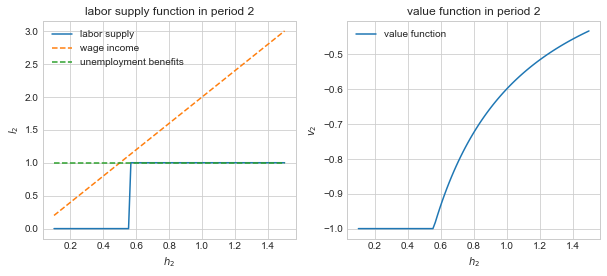

In [8]:
# a. solve
obj_func = lambda l2,h2: v2(l2,h2,b,w,rho,gamma)
l2_vec,v2_vec = solve(h_vec,obj_func)

# b. plot
plot(h_vec,l2_vec,v2_vec,2)

## Question 2

The solution in the **first period** is:

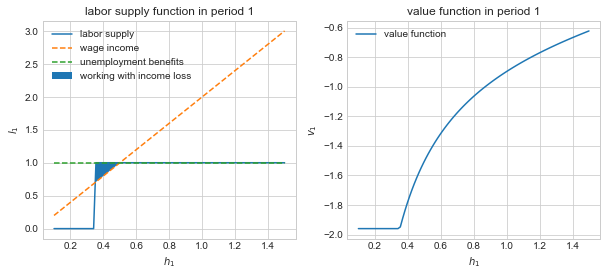

In [9]:
# a. create interpolator
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                bounds_error=False,fill_value=None)
# b. solve
obj_func = lambda l1,h1: v1(l1,h1,b,w,rho,gamma,Delta,v2_interp)
l1_vec,v1_vec = solve(h_vec,obj_func)

# c. plot
plot(h_vec,l1_vec,v1_vec,1)

## Question 3

1. In **period 2**, the worker only works if her potential wage income ($wh_2$) is higher than the unemployment benefits ($b$). 
2. In **period 1**, the worker might work even when she looses income in the current period compared to getting unemployment benefits. The explanation is that she  accumulates human capital by working which increase her utility in period 2.

To explain this further, consider the following **alternative problem**:

$$
\begin{aligned}
v_{1}(h_{1}) &= \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right] \\ 
\text{s.t.}  \\
c_{1}& = \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &= h_1 + \eta l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in \{0,1\}\\
\end{aligned}
$$

where $\eta$ scales the deterministic experience gain from working. Before we had $\eta = 1$. 

If we instead set $\eta = 0$, then the worker will only works in period 1 if $wh_2 > b$ by a margin compensating her for the utility loss of working.

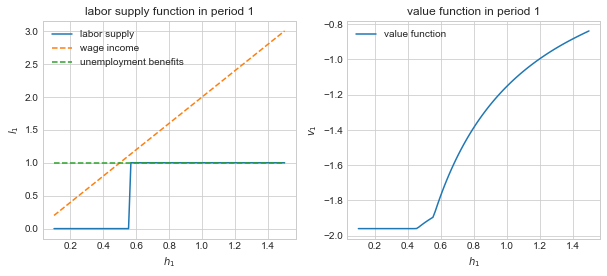

In [10]:
# a. solve
obj_func = lambda l1,h1: v1(l1,h1,b,w,rho,gamma,Delta,v2_interp,eta=0)
l1_vec,v1_vec = solve(h_vec,obj_func)

# b. plot
plot(h_vec,l1_vec,v1_vec,1)

# 2. AS-AD model

In [11]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

In [12]:
par['delta'] = 0.80
par['omega'] = 0.15

In [13]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

## Question 1

Construct the **AD-curve:**

In [14]:
y = sm.symbols('y_t')
v = sm.symbols('v_t')
alpha = sm.symbols('alpha')
h = sm.symbols('h')
b = sm.symbols('b')

AD = 1/(h*alpha)*(v-(1+b*alpha)*y)
AD

(v_t - y_t*(alpha*b + 1))/(alpha*h)

Construct the **SRAS-curve:**

In [15]:
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')
pilag = sm.symbols('\pi_{t-1}')
ylag = sm.symbols('y_{t-1}')
s = sm.symbols('s_t')
slag = sm.symbols('s_{t-1}')

SRAS = pilag + gamma*y- phi*gamma*ylag + s - phi*slag
SRAS

\pi_{t-1} - gamma*phi*y_{t-1} + gamma*y_t - phi*s_{t-1} + s_t

**Find solution:**

In [16]:
y_eq = sm.solve(sm.Eq(AD,SRAS),y)
y_eq[0]

(-\pi_{t-1}*alpha*h + alpha*gamma*h*phi*y_{t-1} + alpha*h*phi*s_{t-1} - alpha*h*s_t + v_t)/(alpha*b + alpha*gamma*h + 1)

In [17]:
pi_eq = AD.subs(y,y_eq[0])
pi_eq

(v_t - (alpha*b + 1)*(-\pi_{t-1}*alpha*h + alpha*gamma*h*phi*y_{t-1} + alpha*h*phi*s_{t-1} - alpha*h*s_t + v_t)/(alpha*b + alpha*gamma*h + 1))/(alpha*h)

In [18]:
sm.init_printing(pretty_print=False)

## Question 2

Create **Python functions**:

In [19]:
AD_func = sm.lambdify((y,v,alpha,h,b),AD)
SRAS_func = sm.lambdify((y,s,ylag,pilag,slag,phi,gamma),SRAS)
y_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha,h,b,phi,gamma),y_eq[0])
pi_eq_func = sm.lambdify((ylag,pilag,v,s,slag,alpha,h,b,phi,gamma),pi_eq)

**Illustrate equilibrium:**

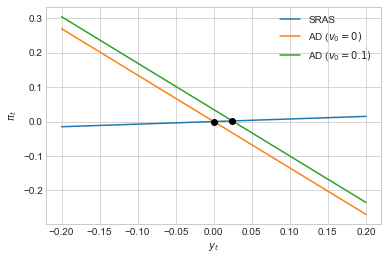

In [20]:
# a. lagged values and shocks 
y0_lag = 0.0
pi0_lag = 0.0
s0 = 0.0
s0_lag = 0.0

# b. current output
y_vec = np.linspace(-0.2,0.2,100)

# c. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)

# SRAS
pi_SRAS = SRAS_func(y_vec,s0,y0_lag,pi0_lag,s0_lag,par['phi'],par['gamma'])
ax.plot(y_vec,pi_SRAS,label='SRAS')

# ADs
for v0 in [0, 0.1]:

    pi_AD = AD_func(y_vec,v0,par['alpha'],par['h'],par['b'])
    ax.plot(y_vec,pi_AD,label=f'AD ($v_0 = {v0})$')
    
    # equilibrium
    eq_y = y_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha'],par['h'],par['b'],par['phi'],par['gamma'])
    eq_pi =pi_eq_func(y0_lag,pi0_lag,v0,s0,s0_lag,par['alpha'],par['h'],par['b'],par['phi'],par['gamma'])
    ax.scatter(eq_y,eq_pi,color='black',zorder=3)

ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$')
ax.legend();

## Question 3

**Allocate memory and draw random shocks**: 

In [21]:
def prep_sim(par,T,seed=1986):
    """ prepare simulation
    
    Args:
    
        par (dict): model parameters
        T (int): number of periods to simulate
        seed (int,optional): seed for random numbers
        
    Returns:
    
        sim (dict): container for simulation results
        
    """
    
    # a. set seed
    if not seed == None:
        np.random.seed(seed)
    
    # b. allocate memory
    sim = {}
    sim['y'] = np.zeros(T)
    sim['pi'] = np.zeros(T)
    sim['v'] = np.zeros(T)
    sim['s'] = np.zeros(T)
    
    # c. draw random shocks
    sim['x_raw'] = np.random.normal(loc=0,scale=1,size=T)
    sim['c_raw'] = np.random.normal(loc=0,scale=1,size=T)
    
    return sim

**Simualte** for $T$ periods:

In [22]:
def simulate(par,sim,T):
    """ run simulation
    
    Args:
    
        par (dict): model parameters
        sim (dict): container for simulation results        
        T (int): number of periods to simulate
                
    """
    
    for t in range(1,T):
        
        # a. shocks
        sim['v'][t] = par['delta']*sim ['v'][t-1] + par['sigma_x']*sim['x_raw'][t]
        sim['s'][t] = par['omega']*sim ['s'][t-1] + par['sigma_c']*sim['c_raw'][t]
        
        # b. output
        sim['y'][t] = y_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                par['alpha'],par['h'],par['b'],par['phi'],par['gamma'])
        
        # c. inflation
        sim['pi'][t] = pi_eq_func(sim['y'][t-1],sim['pi'][t-1],sim['v'][t],sim['s'][t],sim['s'][t-1],
                                  par['alpha'],par['h'],par['b'],par['phi'],par['gamma'])
        

In [23]:
# a. settings
T = 101

# b. prepare simulation
sim = prep_sim(par,T)

# c. overview shocks
sim['x_raw'][:] = 0
sim['c_raw'][:] = 0
sim ['x_raw'][1] = 0.1/par['sigma_x']

# d. run simulation
simulate(par,sim,T)

**$(y_t,\pi_t)$-diagram:**

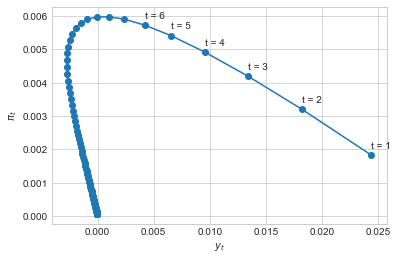

In [24]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(sim['y'][1:],sim['pi'][1:],ls='-',marker='o')
ax.set_xlabel('$y_t$')
ax.set_ylabel('$\pi_t$');
for i in range(1,7):
    ax.text(sim['y'][i],sim['pi'][i]+0.0002,f't = {i}')

**Time paths:**

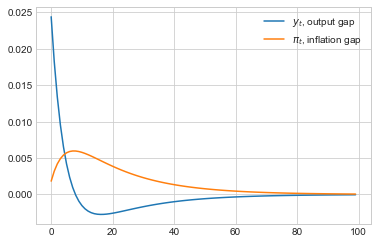

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(0,T-1),sim['y'][1:],label='$y_t$, output gap')
ax.plot(np.arange(0,T-1),sim['pi'][1:],label='$\pi_t$, inflation gap')
ax.legend();

## Question 4

std. of output gap: 1.4118
std. of inflation gap: 1.3406
correlation of output and inflation gap: -0.1499
1st order autocorrelation of output gap: 0.7807
1st order autocorrelation of inflation gap: 0.9869


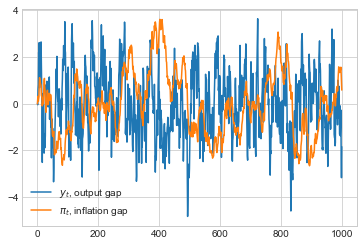

In [26]:
# a. simulate
T = 1000
sim = prep_sim(par,T)
simulate(par,sim,T)

# b. figure
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(np.arange(T),sim['y'],label='$y_t$, output gap')
ax.plot(np.arange(T),sim['pi'],label='$\pi_t$, inflation gap')
ax.legend();

# c. print
def print_sim(sim):
    
    print(f'std. of output gap: {np.std(sim["y"]):.4f}')
    print(f'std. of inflation gap: {np.std(sim["pi"]):.4f}')
    print(f'correlation of output and inflation gap: {np.corrcoef(sim["y"],sim["pi"])[0,1]:.4f}')
    print(f'1st order autocorrelation of output gap: {np.corrcoef(sim["y"][1:],sim["y"][:-1])[0,1]:.4f}')
    print(f'1st order autocorrelation of inflation gap: {np.corrcoef(sim["pi"][1:],sim["pi"][:-1])[0,1]:.4f}')
          
print_sim(sim)          

### Quesiton 5

**The initial plot:**

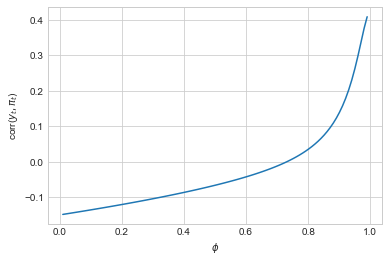

In [27]:
# a. calculate correlations
K = 100
phis = np.linspace(0.01,0.99,K)
corr_y_pi = np.empty(K)

est = par.copy()
for i,phi in enumerate(phis):
    
    # i. update
    est['phi'] = phi
    
    # ii. simulate
    simulate(est,sim,T)
        
    # iii. save
    corr_y_pi[i] = np.corrcoef(sim["y"],sim["pi"])[0,1]

# b. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(phis,corr_y_pi)
ax.set_xlabel('$\phi$')
ax.set_ylabel('corr($y_t,\pi_t$)');

**The optimization:**

In [28]:
# a. copy parameters
est = par.copy()

# b. objective funciton
def obj_func(x,est,sim,T,sim_func):
    """ calculate objective function for estimation of phi
        
    Args:
    
        x (float): trial value for phi
        est (dict): model parameters
        sim (dict): container for simulation results   
        T (int): number of periods to simulate
        sim_func (callable): simulation function
    
    Returns:
    
        obj (float): objective value
    
    """
    
    # i. phi
    est['phi'] = x
    
    # ii. simulate
    sim_func(est,sim,T)
    
    # iii. calcualte objective
    obj = (np.corrcoef(sim["y"],sim["pi"])[0,1]-0.31)**2
    return obj

# c. optimize
result = optimize.minimize_scalar(obj_func,args=(est,sim,T,simulate),
                                  bounds=(0+1e-8,1-1e-8),method='bounded')
    
# d. result
est['phi'] = result.x
print(f'result: phi = {result.x:.3f}')
   
# e. statistics
print('')
simulate(est,sim,T)
print_sim(sim)

result: phi = 0.963

std. of output gap: 1.5264
std. of inflation gap: 0.2726
correlation of output and inflation gap: 0.3100
1st order autocorrelation of output gap: 0.8184
1st order autocorrelation of inflation gap: 0.5559


### Advanced

**Problem:** The estimate for $\phi$ above depends on the seed chosen for the random number generator. This can be illustrated by re-doing the estimation for different seeds:

In [29]:
seeds = [1997,1,17,2018,999] # "randomly chosen seeds"
for seed in seeds:
    
    # a. prepare simulate
    sim_alt = prep_sim(par,T,seed)
    
    # b. run optimizer
    result = optimize.minimize_scalar(obj_func,args=(est,sim_alt,T,simulate),bounds=(0+1e-8,1-1e-8),method='bounded')
    result_alt = optimize.minimize_scalar(obj_func,args=(est,sim_alt,T,ASAD.simulate),bounds=(0+1e-8,1-1e-8),method='bounded')
    
    print(f'seed = {seed:4d}: phi = {result.x:.3f} [{result_alt.x:.3f}]')

seed = 1997: phi = 0.949 [0.949]
seed =    1: phi = 0.973 [0.973]
seed =   17: phi = 0.985 [0.985]
seed = 2018: phi = 0.926 [0.926]
seed =  999: phi = 0.949 [0.949]


**Solution:** To reduce this problem, we need to simulate more than 1,000 periods. To do so it is beneficial to use the fast simulation function provided in **ASAD.py** (optimized using numba):

1. The results in the square brackets above show that this simulation function gives the same results.
2. The results below show that when we simulate 1,000,000 periods the estimate of $\phi$ is approximately 0.983-0.984 irrespective of the seed.

In [30]:
T_alt = 1_000_000
for seed in [1997,1,17,2018,999]:
    
    # a. simulate
    sim_alt = prep_sim(par,T_alt,seed)
    
    # b. run optimizer
    result = optimize.minimize_scalar(obj_func,args=(est,sim_alt,T_alt,ASAD.simulate),bounds=(0+1e-8,1-1e-8),method='bounded')
    
    print(f'seed = {seed:4d}: phi = {result.x:.3f}')

seed = 1997: phi = 0.985
seed =    1: phi = 0.984
seed =   17: phi = 0.983
seed = 2018: phi = 0.983
seed =  999: phi = 0.984


## Question 6

In [31]:
# a. copy parameters
est = par.copy()

# b. objective function
def obj_func_all(x,est,sim,T,sim_func):
    """ calculate objective function for estimation of phi, sigma_c and sigma_c
        
    Args:
    
        x (ndarray): trial values for [phi,sigma_x,sigma_c]
        est (dict): model parameters
        sim (dict): container for simulation results   
        T (int): number of periods to simulate
        sim_func (callable): simulation function
    
    Returns:
    
        obj (float): objective value
    
    """
    
    # i. phi with penalty
    penalty = 0
    if x[0] < 1e-8:
        phi = 1e-8
        penalty += (1-1e-8-x[0])**2
    elif x[0] > 1-1e-8:
        phi = 1-1e-8
        penalty += (1-1e-8-x[0])**2
    else:
        phi = x[0]
    est['phi'] = phi

    # ii. standard deviations (forced to be non-negative)
    est['sigma_x'] = np.sqrt(x[1]**2)
    est['sigma_c'] = np.sqrt(x[2]**2)
    
    # iii. simulate
    sim_func(est,sim,T)
    
    # iv. calcualte objective
    obj = 0
    obj += (np.std(sim['y'])-1.64)**2
    obj += (np.std(sim['pi'])-0.21)**2
    obj += (np.corrcoef(sim['y'],sim['pi'])[0,1]-0.31)**2
    obj += (np.corrcoef(sim['y'][1:],sim['y'][:-1])[0,1]-0.84)**2
    obj += (np.corrcoef(sim['pi'][1:],sim['pi'][:-1])[0,1]-0.48)**2
    
    return obj + penalty

# c. optimize
x0 = [0.98,par['sigma_x'],par['sigma_c']]
result = optimize.minimize(obj_func_all,x0,args=(est,sim,T,simulate))
print(result)

# d. update and print estimates
est['phi'] = result.x[0]
est['sigma_x'] = np.sqrt(result.x[1]**2)
est['sigma_c'] = np.sqrt(result.x[2]**2)    

est_str = ''
est_str += f'phi = {est["phi"]:.3f}, '
est_str += f'sigma_x = {est["sigma_x"]:.3f}, '
est_str += f'sigma_c = {est["sigma_c"]:.3f}'
print(f'\n{est_str}\n')

# e. statistics
sim = prep_sim(est,T)
simulate(est,sim,T)
print_sim(sim)

      fun: 0.0053398007352943155
 hess_inv: array([[ 5.09039186e-03,  8.38423229e-03, -2.52884716e-03],
       [ 8.38423229e-03,  2.56635670e+00,  9.15270835e-02],
       [-2.52884716e-03,  9.15270835e-02,  8.15171926e-02]])
      jac: array([ 9.35303979e-06,  5.21657057e-07, -7.55244400e-07])
  message: 'Optimization terminated successfully.'
     nfev: 44
      nit: 7
     njev: 11
   status: 0
  success: True
        x: array([0.97189233, 3.72758985, 0.21646032])

phi = 0.972, sigma_x = 3.728, sigma_c = 0.216

std. of output gap: 1.6295
std. of inflation gap: 0.2728
correlation of output and inflation gap: 0.3385
1st order autocorrelation of output gap: 0.8183
1st order autocorrelation of inflation gap: 0.4772


### Advanced

**Same problem:** Different seeds give different results.

In [32]:
for seed in seeds:
    
    # a. prepare simulation
    sim_alt = prep_sim(par,T,seed)
    
    # b. run optimizer
    est = par.copy()
    x0 = [0.98,par['sigma_x'],par['sigma_c']]
    result = optimize.minimize(obj_func_all,x0,args=(est,sim_alt,T,simulate))
    
    # c. update and print estimates
    est['phi'] = result.x[0]
    est['sigma_x'] = np.sqrt(result.x[1]**2)
    est['sigma_c'] = np.sqrt(result.x[2]**2)    
    
    est_str = ''
    est_str += f' phi = {est["phi"]:.3f},'
    est_str += f' sigma_x = {est["sigma_x"]:.3f},'
    est_str += f' sigma_c = {est["sigma_c"]:.3f}'
    print(f'seed = {seed:4d}: {est_str}')

seed = 1997:  phi = 0.958, sigma_x = 4.305, sigma_c = 0.231
seed =    1:  phi = 0.969, sigma_x = 4.246, sigma_c = 0.217
seed =   17:  phi = 0.975, sigma_x = 4.109, sigma_c = 0.206
seed = 2018:  phi = 0.956, sigma_x = 4.027, sigma_c = 0.240
seed =  999:  phi = 0.962, sigma_x = 3.665, sigma_c = 0.207


**Same solution:** Simulate more periods (and use the faster simulation function).

In [34]:
T_alt = 1_000_000
for seed in seeds:
    
    # a. simulate
    sim_alt = prep_sim(par,T_alt,seed)
    
    # b. run optimizer
    est = par.copy()
    x0 = [0.95,par['sigma_x'],par['sigma_c']]
    result = optimize.minimize(obj_func_all,x0,args=(est,sim_alt,T_alt,ASAD.simulate))
    
    # c. update and print estimates
    est['phi'] = result.x[0]
    est['sigma_x'] = np.sqrt(result.x[1]**2)
    est['sigma_c'] = np.sqrt(result.x[2]**2)    
    
    est_str = ''
    est_str += f' phi = {est["phi"]:.3f},'
    est_str += f' sigma_x = {est["sigma_x"]:.3f},'
    est_str += f' sigma_c = {est["sigma_c"]:.3f}'
    print(f'seed = {seed:4d}: {est_str}')

seed = 1997:  phi = 0.990, sigma_x = 3.994, sigma_c = 0.222
seed =    1:  phi = 0.990, sigma_x = 3.982, sigma_c = 0.222
seed =   17:  phi = 0.989, sigma_x = 3.984, sigma_c = 0.222
seed = 2018:  phi = 0.989, sigma_x = 3.974, sigma_c = 0.222
seed =  999:  phi = 0.990, sigma_x = 3.990, sigma_c = 0.222


# 3. Exchange economy

In [34]:
# a. parameters
N = 50_000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
zeta = 1
gamma = 0.8

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu,Sigma,size=N))                         
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

## Question 1

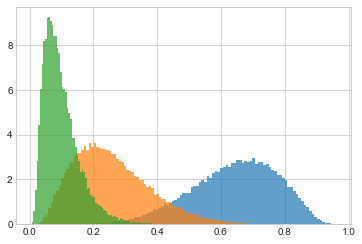

In [35]:
# a. calculate
budgetshares = betas

# b. histograms
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for i in range(3):
    ax.hist(budgetshares[:,i],bins=100,alpha=0.7,density=True)

## Question 2

In [36]:
def excess_demands(budgetshares,p1,p2,e1,e2,e3):
    """ calculate excess demands for good 1, 2 and 3
    
    Args:
    
        budgetshares (ndarray): budgetshares for each good for all consumers
        p1 (float): price of good 1
        p2 (float): price of good 2
        e1 (ndrarray): endowments of good 1
        e2 (ndrarray): endowments of good 2
        e3 (ndrarray): endowments of good 3
        
    Returns:
    
        ed_1 (float): excess demands for good 1
        ed_2 (float): excess demands for good 2
        ed_3 (float): excess demands for good 3        
    
    """
    
    # a. income
    I = p1*e1+p2*e2+1*e3
    
    # b. demands
    demand_1 = np.sum(budgetshares[:,0]*I/p1)
    demand_2 = np.sum(budgetshares[:,1]*I/p2)
    demand_3 = np.sum(budgetshares[:,2]*I) # p3 = 1, numeraire
    
    # b. supply
    supply_1 = np.sum(e1)
    supply_2 = np.sum(e2)
    supply_3 = np.sum(e3)
    
    # c. excess demand
    ed_1 = demand_1-supply_1
    ed_2 = demand_2-supply_2
    ed_3 = demand_3-supply_3
    
    return ed_1,ed_2,ed_3

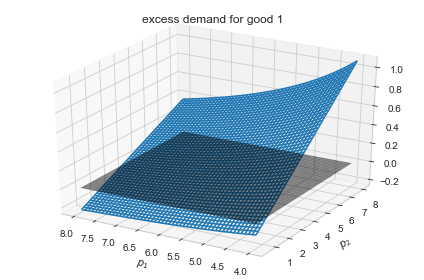

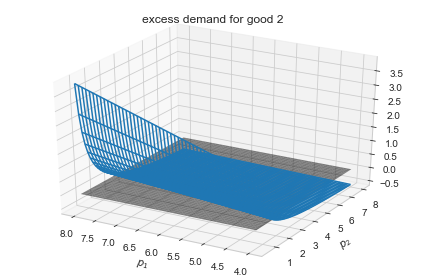

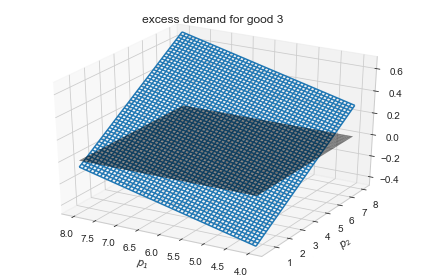

In [37]:
# a. calculate on grid
K = 50

p1_vec = np.linspace(4,8,K)
p2_vec = np.linspace(0.5,8,K)
p1_mat,p2_mat = np.meshgrid(p1_vec,p2_vec,indexing='ij')

ed1_mat = np.empty((K,K))
ed2_mat = np.empty((K,K))
ed3_mat = np.empty((K,K))
for (i,p1),(j,p2) in product(enumerate(p1_vec),enumerate(p2_vec)):
    ed1_mat[i,j],ed2_mat[i,j],ed3_mat[i,j] = excess_demands(budgetshares,p1,p2,e1,e2,e3)
    
# b. plot
fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_wireframe(p1_mat,p2_mat,ed1_mat/N)
ax.plot_surface(p1_mat,p2_mat,np.zeros((K,K)),alpha=0.5,color='black',zorder=99)
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')
ax.set_title('excess demand for good 1')
ax.invert_xaxis()
fig.tight_layout()

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_wireframe(p1_mat,p2_mat,ed2_mat/N)
ax.plot_surface(p1_mat,p2_mat,np.zeros((K,K)),alpha=0.5,color='black',zorder=99)
ax.set_title('excess demand for good 2')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')
ax.invert_xaxis();
fig.tight_layout()

fig = plt.figure()
ax = fig.add_subplot(1,1,1,projection='3d')
ax.plot_wireframe(p1_mat,p2_mat,ed3_mat/N)
ax.plot_surface(p1_mat,p2_mat,np.zeros((K,K)),alpha=0.5,color='black',zorder=99)
ax.set_title('excess demand for good 3')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')
ax.invert_xaxis();
fig.tight_layout()

## Questions 3

**Function for finding the equilibrium:**

In [38]:
def find_equilibrium(budgetshares,p1,p2,e1,e2,e3,kappa=0.5,eps=1e-8,maxiter=5000):
    """ find equilibrium prices
    
    Args:
    
        budgetshares (ndarray): budgetshares for each good for all consumers
        p1 (float): price of good 1
        p2 (float): price of good 2
        e1 (ndrarray): endowments of good 1
        e2 (ndrarray): endowments of good 2
        e3 (ndrarray): endowments of good 3
        kappa (float,optional): adjustment aggresivity parameter
        eps (float,optional): tolerance for convergence
        maxiter (int,optinal): maximum number of iteration
        
    Returns:
    
        p1 (ndarray): equilibrium price for good 1
        p2 (ndarray): equilibrium price for good 2
    
    """
    
    it = 0
    while True:

        # a. step 1: excess demands
        ed_1,ed_2,_ed3 = excess_demands(budgetshares,p1,p2,e1,e2,e3)
        
        # b: step 2: stop?
        if  (np.abs(ed_1) < eps and np.abs(ed_2) < eps) or it >= maxiter:
            print(f'(p1,p2) = [{p1:.4f} {p2:.4f}] -> excess demands = [{ed_1:.4f} {ed_2:.4f}] (iterations: {it})')
            break    
    
        # c. step 3: update p1 and p2
        N = budgetshares.shape[0]
        p1 = p1 + kappa*ed_1/N
        p2 = p2 + kappa*ed_2/N
            
        # d. step 4: return             
        it += 1    

    return p1,p2

**Apply algorithm:**

In [39]:
# a. guess prices are equal to the average beta
betas_mean = np.mean(betas,axis=0)
p1_guess,p2_guess,_p3_guess = betas_mean/betas_mean[-1]

# b. find equilibrium
p1,p2 = find_equilibrium(budgetshares,p1_guess,p2_guess,e1,e2,e3)

(p1,p2) = [6.4901 2.6167] -> excess demands = [0.0000 0.0000] (iterations: 2416)


**Check excess demands:**

In [40]:
assert np.all(np.abs(np.array(excess_demands(budgetshares,p1,p2,e1,e2,e3)) < 1e-6))

## Questions 4

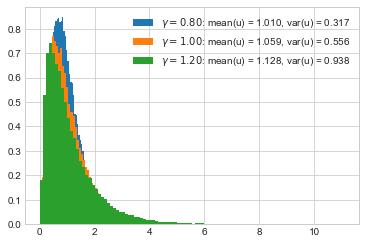

In [41]:
# a. income
I = p1*e1+p2*e2+1*e3

# b. baseline utility
x = budgetshares*np.reshape(I,(N,1))/np.array([p1,p2,1])
base_utility = np.prod(x**betas,axis=1)
        
# c. plot utility       
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for gamma_now in [gamma,1.0,1.2]:
    utility = base_utility**gamma_now
    ax.hist(utility,bins=100,density=True,
            label=f'$\gamma = {gamma_now:.2f}$: mean(u) = {np.mean(utility):.3f}, var(u) = {np.var(utility):.3f}')
ax.legend();

### Question 5

In [42]:
# a. equalize endowments 
e1_equal = np.repeat(np.mean(e1),N)
e2_equal = np.repeat(np.mean(e2),N)
e3_equal = np.repeat(np.mean(e3),N)
print(f'e_equal = [{e1_equal[0]:.2f},{e2_equal[0]:.2f},{e3_equal[0]:.2f}]')

# b. find equilibrium
p1_equal,p2_equal = find_equilibrium(budgetshares,p1_guess,p2_guess,e1_equal,e2_equal,e3_equal)

e_equal = [1.00,0.99,1.00]
(p1,p2) = [6.4860 2.6172] -> excess demands = [0.0000 0.0000] (iterations: 2404)


**Check excess demands:**

In [43]:
assert np.all(np.abs(np.array(excess_demands(budgetshares,p1_equal,p2_equal,e1_equal,e2_equal,e3_equal))< 1e-6))

**Plot utility:**

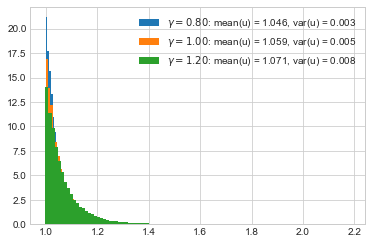

In [44]:
# a. income
I_equal = p1_equal*e1_equal+p2_equal*e2_equal+1*e3_equal

# b. baseline utility
x = budgetshares*np.reshape(I_equal,(N,1))/np.array([p1_equal,p2_equal,1])
base_utility_equal = np.prod(x**betas,axis=1)
        
# c. plot utility       
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
for gamma_now in [gamma,1.0,1.2]:
    utility = base_utility_equal**gamma_now
    ax.hist(utility,bins=100,density=True,
            label=f'$\gamma = {gamma_now:.2f}$: mean(u) = {np.mean(utility):.3f}, var(u) = {np.var(utility):.3f}')
ax.legend();

**Compare prices with baseline:**

In [45]:
print(f'baseline: p1 = {p1:.4f}, p2 = {p2:.4f}')
print(f'   equal: p1 = {p1_equal:.4f}, p2 = {p2_equal:.4f}')

baseline: p1 = 6.4901, p2 = 2.6167
   equal: p1 = 6.4860, p2 = 2.6172


**Conclusions:** The relative prices of good 1 and good 2 *increase* slightly when endowments are equalized. (This can, however, be shown to disappear when $N \rightarrow \infty$.)

Economic behavior (demand and supply), and therefore equilibrium prices, are independent of $\gamma$, which thus only affects utility. 

Irrespective of $\gamma$ we have:

1. Equalization of endowments implies a utility floor of approximately 1 because everyone then get approximately one unit of each good.
2. The variance of utility always decreases when endowments are equalized.
3. The remaining inequality in utility when endowments are equalized must be driven by preferences (see below).

The effect on the mean of utility of equalizing endowments depends on whether $\gamma$ is below, equal to or above one:

1. For $\gamma = 0.8 < 1.0$ the mean utility *increases* ("decreasing returns to scale").
2. For $\gamma = 1.0$ the mean utility is *unchanged* ("constant returns to scale").
3. For $\gamma = 1.2 > 1.0$ the utility mean *decreases* ("increasing returns to scale").

**Additional observation:** When endowments are equalized those with high utility have preferences which differ from the mean.

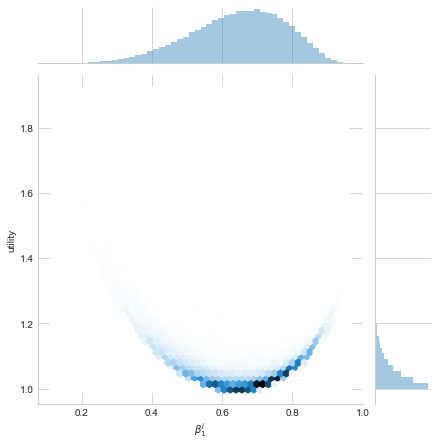

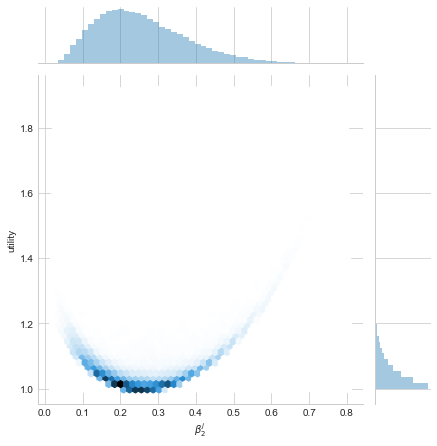

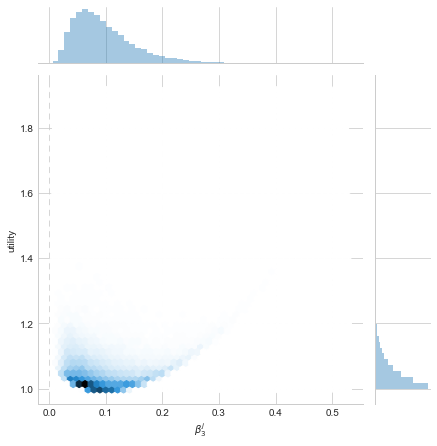

In [46]:
for i in range(3):
    sns.jointplot(betas[:,i],base_utility_equal,kind='hex').set_axis_labels(f'$\\beta^j_{i+1}$','utility')